In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score
from sklearn.svm import SVC
from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import clone
motifs = ['AP2', 'SOX2-OCT4', 'CREB', 'UA8', 'BARHL2', 'MEF2', 'TAL1', 'TCF7L2', 'UA12', 'E2F1', 
          'HSF1', 'v-JUN', 'UA11', 'SREBF1', 'GATA1', 'UA10', 'E2F4', 'UA2', 'SP1', 'SRF', 'UA3', 
          'BHLHE40', 'ESR1', 'REST', 'UA6', 'GATA3', 'UA1', 'ETS1', 'POU2F2', 'USF', 'UA5', 
          'CTCF-ext', 'ZEB1', 'v-Maf', 'EBF1', 'ZNF143-ext', 'RXRA', 'PAX5', 'FOXA', 'TCF12', 
          'B-Box', 'ZNF143', 'CEBPB', 'RFX5', 'TEAD1', 'NFE2', 'NR2C2', 'UA4', 'CTCF', 'ZNF281', 
          'TBP', 'GFI1', 'ELK4', 'STAT1', 'MAX', 'CREB-ext', 'NR3C1', 'SOX2', 'AP1', 'UA9', 'RUNX1', 
          'STAT2', 'ZNF263', 'NFY', 'EGR1', 'ESRRA', 'ELF1', 'PU1', 'MYC', 'YY1', 'A-Box', 'UA7', 
          'GABP', 'NRF1', 'NFY-UA2', 'NFKB1', 'GATA1-ext', 'HNF4', 'PRDM1']

/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def getMotifClustersByCorrelation(X, num_motifs=79, thresh=0.2):
    link = linkage(X.T, 'single', 'correlation')
    cindexes = list(range(num_motifs))
    for l in link:
        c1 = int(l[0])
        c2 = int(l[1])
        distance = l[2]
        if distance < 0.2:
            cindexes.append([c1, c2])

    all_clusters = [[i,] for i in range(79)]
    for l in link:
        c1 = int(l[0])
        c2 = int(l[1])
        all_clusters.append(all_clusters[c1] + all_clusters[c2])

    cindexes = list(range(num_motifs))
    for i,l in enumerate(link):
        c1 = int(l[0])
        c2 = int(l[1])
        if l[2] < 0.2:
            cindexes.append(num_motifs+i)
            cindexes.remove(c1)
            cindexes.remove(c2)

    grouped_clusters = [all_clusters[i] for i in cindexes]
    motifs_to_use = []
    for g in grouped_clusters:
        motifs_to_use.append(X_train.columns[g[0]])
    return motifs_to_use, grouped_clusters

In [4]:


def load_data(region_file, motif_dir_prefix, post_fix=''):

    columns = ["window_chrom", "window_start", "window_end", "window_name", "label", "active_promoters_in_window", "enhancer_distance_to_promoter"]

    windows = pd.read_csv(region_file, names=columns, sep="\t", header=None, index_col=False)
    ftype='window'
    for i,name in enumerate(motifs):
        key = name
        b = pd.read_csv(motif_dir_prefix + name + post_fix + ".bed", sep="\t", header=None, names=[ftype + '_chrom', ftype + '_start', ftype + '_end', key])

        b[key] = b[key] * 1.0 / (b[ftype + "_end"] - b[ftype+"_start"])

        windows = pd.merge(windows, b, on=[ftype + '_chrom', ftype + '_start', ftype + '_end'], how="left", indicator=False)

    windows = windows.set_index('window_name')
    columns.remove('window_name')
    predictors_df = windows.drop(columns, axis=1)
    labels = windows['label']
    predictors_df = predictors_df.fillna(0)
    return windows, predictors_df, labels



In [5]:
def evaludate_data(X, y, n_estimators=4000, classifier_class=GradientBoostingClassifier):
    scoring = ['f1', 'roc_auc', 'precision', 'recall']
    estimator = classifier_class(n_estimators = n_estimators, learning_rate = 0.1, max_depth = 5, max_features = 'log2', random_state = 12)
    estimator = make_pipeline(StandardScaler(), estimator)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    cv = StratifiedKFold(y = y_train, n_folds = 8, shuffle = True, random_state = 12)
    scores = {}
    for s in scoring:
        scores[s] = cross_val_score(estimator, X_train, y_train, cv=cv, scoring=s, n_jobs=-1)
    estimator = estimator.fit(X_train, y_train)
    return (scores, (X_train, X_test, y_train, y_test), estimator, cv)

In [6]:
estimators_sizes = [100,200,500,1000,2000,5000,7000,10000]
estimators_sizes_large = [20000, 40000, 80000]

def _worker(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train)

    return (estimator, (X_train, y_train, X_test, y_test))

def test_overfitting(X, y, classifier_class, n_trees ):
    #training_errors = {}
    #testing_errors = {}
    cv = StratifiedKFold( y, n_folds=10, shuffle=True, random_state=42)
    with Parallel(n_jobs=10) as parallel:
        estimator = GradientBoostingClassifier(n_estimators = n_trees, learning_rate = 0.1, max_depth = 5, max_features = 'log2', random_state = n_trees)
        results = parallel(delayed(_worker)(clone(estimator),X.ix[train,:],y.ix[train],X.ix[test,:],y.ix[test]) for train, test in cv)
        #print(n_trees, "finished")
    return results


def _worker_chrom(estimator, X, y, windows, val_chroms):
    X_test = X.ix[[i for i in X.index if windows.ix[i,'window_chrom'] in val_chroms], :]
    y_test = y[X_test.index]
    X_train = X.drop(X_test.index)
    y_train = y[X_train.index]
    estimator.fit(X_train, y_train)
    return (estimator, (X_train, y_train, X_test, y_test))

def test_overfitting_chrom(X, y, windows, n_trees):
    chroms = list(set(windows.ix[:, 0]))
    idxes = set([tuple(sorted(np.random.choice(np.arange(len(chroms)), 2, replace=False))) for _ in range(40)])
    idxes = list(idxes)[:20]
    with Parallel(n_jobs=10) as parallel:
        estimator = GradientBoostingClassifier(n_estimators = n_trees, learning_rate = 0.1, max_depth = 5, max_features = 'log2', random_state = n_trees)
        results = parallel(delayed(_worker_chrom)(clone(estimator),
                                                  X, y, windows, [chroms[i1], chroms[i2]]) for i1, i2 in idxes)
        #print(n_trees, "finished")
    return results

In [8]:
def getLosses(data):
    train_loss = []
    test_loss = []
    for estimator, d in data:
        train_loss.append([])
        test_loss.append([])
        for pred in estimator.staged_decision_function(d[0]):
            train_loss[-1].append(estimator.loss_(d[1],pred))
        for pred in estimator.staged_decision_function(d[2]):
            test_loss[-1].append(estimator.loss_(d[3], pred))
    return np.array(train_loss).mean(axis=0), np.array(test_loss).mean(axis=0)

def plotAccuracies(training_scores, testing_scores, indexes):
    training_scores_avg = []
    testing_scores_avg = []
    for n in indexes:
        training_scores_avg.append(np.array(training_scores[n]).mean(axis=0))
        testing_scores_avg.append(np.array(testing_scores[n]).mean(axis=0))
    
    for l in zip(range(3),["training {}".format(i) for i in ['accuracy', 'precision','recall']]) :
        pylab.plot(indexes, np.array(training_scores_avg)[:,l[0]], label=l[1])
    for l in zip(range(3),["test {}".format(i) for i in ['accuracy', 'precision','recall']]) :
        pylab.plot(indexes, np.array(testing_scores_avg)[:,l[0]], label=l[1])
    pylab.legend(loc="lower right")

In [9]:
def get_scores(estimators):
    scores = []
    for estimator, (_ , _, test_data, test_label) in estimators:
        test_prob = estimator.predict_proba(test_data)
        test_pred = estimator.predict(test_data)
        scores.append([accuracy_score(test_label, test_pred),
                       f1_score(test_label, test_pred), 
                       precision_score(test_label, test_pred), 
                       recall_score(test_label, test_pred),
                       average_precision_score(test_label, test_prob[:, 1]),
                       roc_auc_score(test_label, test_prob[:, 1])])
    scores = pd.DataFrame(scores, columns=['accuracy', 'f1', 'precision', 'recall', 'auprc', 'auroc'])
    return scores

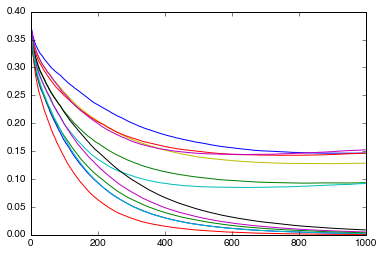

In [10]:
results = {}
for cell in ['HeLa-S3', 'NHEK', 'K562', 'GM12878', 'HUVEC', 'IMR90']:
    
    curr_data, curr_X, curr_y = load_data("targetfinder-master/%s/output-epw/windows.bed" % cell, 
                                            "targetfinder-master/%s/output-epw/motifs/%s.window." % (cell, cell))
    estimators_tf = test_overfitting(curr_X, curr_y, "gradient", 1000)
    train_loss_tf, test_loss_tf = getLosses(estimators_tf)
    pylab.plot(train_loss_tf)
    pylab.plot(test_loss_tf)
    curr_scores = get_scores(estimators_tf)
    results[cell] = (estimators_tf, train_loss_tf, test_loss_tf, curr_scores)

In [11]:
for c in results:
    print(c)
    print(results[c][-1])
    print()

GM12878
   accuracy        f1  precision    recall     auprc     auroc
0  0.981724  0.771831   0.958042  0.646226  0.845482  0.939852
1  0.983980  0.804408   0.966887  0.688679  0.859169  0.949194
2  0.979468  0.746518   0.911565  0.632075  0.798075  0.916708
3  0.979689  0.741379   0.941606  0.611374  0.827505  0.935576
4  0.980140  0.751412   0.930070  0.630332  0.815822  0.945749
5  0.982397  0.782123   0.952381  0.663507  0.825995  0.930410
6  0.981494  0.765714   0.964029  0.635071  0.838932  0.948930
7  0.983525  0.798898   0.953947  0.687204  0.845897  0.934424
8  0.984654  0.817204   0.944099  0.720379  0.845358  0.940274
9  0.984202  0.809783   0.949045  0.706161  0.854127  0.941758

HeLa-S3
   accuracy        f1  precision    recall     auprc     auroc
0  0.989053  0.872611   0.978571  0.787356  0.919226  0.966473
1  0.987411  0.850649   0.977612  0.752874  0.914778  0.968561
2  0.990148  0.886076   0.985915  0.804598  0.947976  0.980265
3  0.988506  0.864516   0.985294  0.77

/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklea

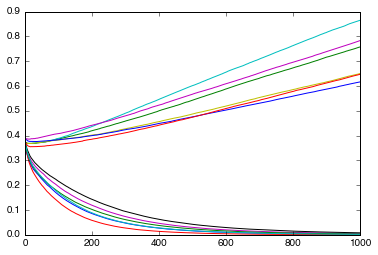

In [12]:
chrom_split_results = {}
for cell in ['HeLa-S3', 'NHEK', 'K562', 'GM12878', 'HUVEC', 'IMR90']:
    
    curr_data, curr_X, curr_y = load_data("targetfinder-master/%s/output-epw/windows.bed" % cell, 
                                            "targetfinder-master/%s/output-epw/motifs/%s.window." % (cell, cell))
    estimators_tf = test_overfitting_chrom(curr_X, curr_y, curr_data, 1000)
    train_loss_tf, test_loss_tf = getLosses(estimators_tf)
    pylab.plot(train_loss_tf)
    pylab.plot(test_loss_tf)
    curr_scores = get_scores(estimators_tf)
    chrom_split_results[cell] = (estimators_tf, train_loss_tf, test_loss_tf, curr_scores)

In [13]:
for c in chrom_split_results:
    print(c)
    print(chrom_split_results[c][-1])
    print()

GM12878
    accuracy       f1  precision    recall     auprc     auroc
0   0.924475  0.00000        0.0  0.000000  0.166787  0.648824
1   0.937723  0.00000        0.0  0.000000  0.136867  0.623847
2   0.958812  0.00000        0.0  0.000000  0.060055  0.544346
3   0.913089  0.00000        0.0  0.000000  0.111776  0.565584
4   0.945743  0.00000        0.0  0.000000  0.093124  0.645502
5   0.963784  0.00000        0.0  0.000000  0.063830  0.554590
6   0.947572  0.00000        0.0  0.000000  0.080230  0.590847
7   0.956308  0.00000        0.0  0.000000  0.069378  0.568142
8   0.968016  0.00000        0.0  0.000000  0.041370  0.507891
9   0.953959  0.00000        0.0  0.000000  0.058430  0.525549
10  0.960191  0.00000        0.0  0.000000  0.055685  0.571609
11  0.958227  0.00000        0.0  0.000000  0.064042  0.594441
12  0.953474  0.00000        0.0  0.000000  0.055196  0.569369
13  0.938304  0.00939        1.0  0.004717  0.132607  0.580827
14  0.955201  0.00000        0.0  0.000000  0.0

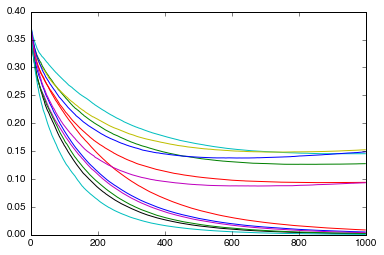

In [14]:
random_results = {}
for cell in ['K562', 'GM12878', 'HUVEC', 'IMR90', 'HeLa-S3', 'NHEK']:
    
    curr_data, curr_X, curr_y = load_data("targetfinder-master/%s/output-epw/windows.bed" % cell, 
                                          "targetfinder-master/%s/output-epw/motifs_shuffled/%s.window." % (cell, cell),
                                          post_fix='.all_shuffled')
    estimators_tf = test_overfitting(curr_X, curr_y, "gradient", 1000)
    train_loss_tf, test_loss_tf = getLosses(estimators_tf)
    pylab.plot(train_loss_tf)
    pylab.plot(test_loss_tf)
    curr_scores = get_scores(estimators_tf)
    random_results[cell] = (estimators_tf, train_loss_tf, test_loss_tf, curr_scores)

In [15]:
random_results['K562'][-1]

,accuracy,f1,precision,recall,auprc,auroc
0,0.984330,0.811594,0.952381,0.707071,0.891671,0.947251
1,0.985294,0.822157,0.972414,0.712121,0.868409,0.955979
2,0.985294,0.822157,0.972414,0.712121,0.884610,0.943448
3,0.986741,0.841499,0.979866,0.737374,0.909061,0.965742
4,0.987946,0.857955,0.980519,0.762626,0.903314,0.953438
5,0.984571,0.811765,0.971831,0.696970,0.862726,0.935314
6,0.985535,0.826590,0.966216,0.722222,0.840790,0.933872
7,0.987702,0.853868,0.980263,0.756345,0.894571,0.933391
8,0.980950,0.766962,0.915493,0.659898,0.824851,0.941896
9,0.983844,0.802360,0.957746,0.690355,0.884627,0.951769


In [16]:
for c in random_results:
    print(c)
    print(random_results[c][-1])
    print()

GM12878
   accuracy        f1  precision    recall     auprc     auroc
0  0.982175  0.776204   0.971631  0.646226  0.828002  0.916192
1  0.983755  0.803279   0.954545  0.693396  0.872199  0.951964
2  0.981047  0.762712   0.950704  0.636792  0.820627  0.923400
3  0.979237  0.734104   0.940741  0.601896  0.827707  0.929753
4  0.979689  0.748603   0.911565  0.635071  0.814146  0.935442
5  0.982397  0.784530   0.940397  0.672986  0.854645  0.949106
6  0.984202  0.806630   0.966887  0.691943  0.851409  0.946322
7  0.981945  0.775281   0.951724  0.654028  0.855100  0.935217
8  0.983751  0.806452   0.931677  0.710900  0.850463  0.943729
9  0.983525  0.807388   0.910714  0.725118  0.858240  0.944220

HeLa-S3
   accuracy        f1  precision    recall     auprc     auroc
0  0.992611  0.916409   0.993289  0.850575  0.936302  0.971405
1  0.987137  0.845902   0.984733  0.741379  0.909371  0.965273
2  0.989327  0.874598   0.992701  0.781609  0.946491  0.976734
3  0.989053  0.872611   0.978571  0.78

/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/caofan/anaconda3/lib/python3.5/site-packages/sklea

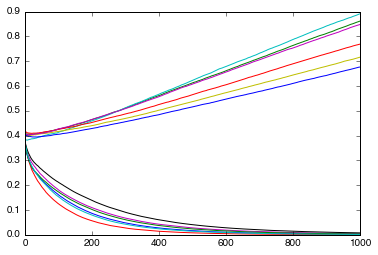

In [17]:
chrom_split_random_results = {}
for cell in ['HeLa-S3', 'NHEK', 'K562', 'GM12878', 'HUVEC', 'IMR90']:
    
    curr_data, curr_X, curr_y = load_data("targetfinder-master/%s/output-epw/windows.bed" % cell, 
                                          "targetfinder-master/%s/output-epw/motifs_shuffled/%s.window." % (cell, cell),
                                          post_fix='.all_shuffled')
    estimators_tf = test_overfitting_chrom(curr_X, curr_y, curr_data, 1000)
    train_loss_tf, test_loss_tf = getLosses(estimators_tf)
    pylab.plot(train_loss_tf)
    pylab.plot(test_loss_tf)
    curr_scores = get_scores(estimators_tf)
    chrom_split_random_results[cell] = (estimators_tf, train_loss_tf, test_loss_tf, curr_scores)

In [18]:
for c in chrom_split_random_results:
    print(c)
    print(chrom_split_random_results[c][-1])
    print()

GM12878
    accuracy   f1  precision  recall     auprc     auroc
0   0.923907  0.0        0.0     0.0  0.092429  0.499155
1   0.966455  0.0        0.0     0.0  0.036865  0.521280
2   0.941799  0.0        0.0     0.0  0.069396  0.516352
3   0.957036  0.0        0.0     0.0  0.055202  0.577211
4   0.946563  0.0        0.0     0.0  0.091423  0.565620
5   0.944444  0.0        0.0     0.0  0.120381  0.638465
6   0.937723  0.0        0.0     0.0  0.092847  0.569079
7   0.961674  0.0        0.0     0.0  0.057730  0.625310
8   0.951847  0.0        0.0     0.0  0.057682  0.550089
9   0.910947  0.0        0.0     0.0  0.106472  0.505897
10  0.935970  0.0        0.0     0.0  0.099128  0.593577
11  0.959263  0.0        0.0     0.0  0.072929  0.656104
12  0.952723  0.0        0.0     0.0  0.057350  0.569580
13  0.965192  0.0        0.0     0.0  0.053769  0.587069
14  0.944567  0.0        0.0     0.0  0.068520  0.550300
15  0.948184  0.0        0.0     0.0  0.066264  0.611415
16  0.958227  0.0      

In [19]:
real_f1s = dict([(c, results[c][-1].ix[:, 'f1'].mean()) for c in results])
random_f1s = dict([(c, random_results[c][-1].ix[:, 'f1'].mean()) for c in random_results])
real_auprcs = dict([(c, results[c][-1].ix[:, 'auprc'].mean()) for c in results])
random_auprcs = dict([(c, random_results[c][-1].ix[:, 'auprc'].mean()) for c in random_results])
real_aurocs = dict([(c, results[c][-1].ix[:, 'auroc'].mean()) for c in results])
random_aurocs = dict([(c, random_results[c][-1].ix[:, 'auroc'].mean()) for c in random_results])

In [33]:
'''
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
'''
inch = 25.4
col1Width = 87 / inch
def plot_bar_plot(real, random, title):
    colors = [(214, 39, 40), (31, 119, 180), (44, 160, 44), (148, 103, 189), (255, 127, 14), (140, 86, 75)]
    for i in range(len(colors)):    
        r, g, b = colors[i]    
        colors[i] = (r / 255., g / 255., b / 255.) 

    fig = plt.figure(figsize=(col1Width*0.7, col1Width))
    width = 0.2
    for i,c in enumerate(['K562', 'GM12878', 'HeLa-S3', 'HUVEC', 'IMR90', 'NHEK']):

        ax = fig.add_subplot(3,2,i+1)
        rects = ax.bar([1,2], [real[c], random[c]], width=width, edgecolor='none', color=colors[i])

        ax.set_xticks([1 + width/2, 2 + width/2])
        ax.set_xticklabels(['Real', 'Shuffled'], fontsize=9)

        ax.get_xaxis().tick_bottom()
        ax.tick_params(axis='x', direction='out', top='off', bottom='off')

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if i % 2 == 1:
            ax.spines['left'].set_visible(False)
            ax.tick_params(axis='y', direction='out', left='off', right='off')
            ax.set_yticklabels([])
        else:
            ax.tick_params(axis='y', direction='out')
            ax.get_yaxis().tick_left()
            ax.set_yticks([0, 0.5, 1])
            ax.set_yticklabels(["0", "0.5", "1"])
        ax.set_ylim([0,1])
        ax.set_title(c, fontsize=9)
        for rect in rects:
            height = rect.get_height()
            offset = ax.get_ylim()[1] * 0.002
            cstr = "%.2f"%float(height)
            ax.text(rect.get_x()+rect.get_width()/2., height + offset, cstr,
                    ha='center', va='bottom', fontsize=8)
        if i == 2:
            if title == 'f1':
                ax.set_ylabel('Performance (F1)', fontsize=9)
            elif title == 'auprc':
                ax.set_ylabel('Performance (auPRC)', fontsize=9)
            elif title == 'auroc':
                ax.set_ylabel('Performance (auROC)', fontsize=9)

    fig.tight_layout()
    fig.savefig("targetfinder_prediction_with_motif_%s.png"%title, dpi=600)
    fig.savefig("targetfinder_prediction_with_motif_%s.pdf"%title, dpi=600)

    
def make_plot(title):
    print(title)
    real = dict([(c, results[c][-1].ix[:, title].mean()) for c in results])
    random = dict([(c, random_results[c][-1].ix[:, title].mean()) for c in random_results])
    plot_bar_plot(real, random, title)

f1
auprc
auroc


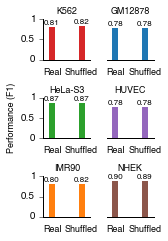

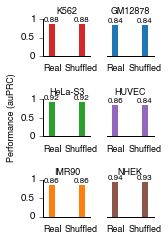

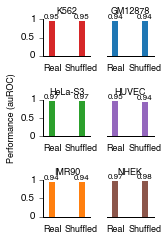

In [34]:
make_plot('f1')
make_plot('auprc')
make_plot('auroc')

In [22]:
import pickle
with open("motif_results.pickle", 'wb') as out:
    pickle.dump(results, out)
with open("motif_random_results.pickle", 'wb') as out:
    pickle.dump(random_results, out)
with open("motif_chrom_split_results.pickle", 'wb') as out:
    pickle.dump(chrom_split_results, out)
with open("motif_chrom_split_random_results.pickle", 'wb') as out:
    pickle.dump(chrom_split_random_results, out)

(-1, 21)

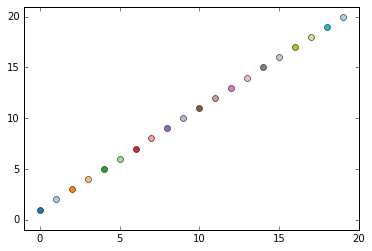

In [152]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i,p in enumerate(tableau20):
    plt.plot(i,i+1, color=[x/255. for x in p], marker="o")
plt.xlim(-1, len(tableau20))
plt.ylim(-1, len(tableau20)+1)